### Here we develop some new metrics and test them on fake data

In [1]:
import imagery_psychophysics.src.variational as very
import numpy as np
import math
import copy
from matplotlib import pyplot as plt
from os.path import join
from PIL.Image import open as open_image
from mpl_toolkits.axes_grid1 import ImageGrid

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags__LAn64.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX TITAN X (0000:01:00.0)


### Create the fake data

Set up basic model parameters and objects

In [2]:
##model variable parameters
K = 5
D1,D2 = 8,8
dispersion = 2.2
pon,poff = 0.9, .1

##number of objects
nObj = very.numObjects()
nObj.set_value(K)

##dispersion on category prior
pDisp = very.priorDispersion()
pDisp.set_value(dispersion)

##resolution of object map Z
nPixels = very.numPixels()
nPixels.set_value(D1,D2)

##category prior and object map
catProb = very.categoryProbs(nObj,pDisp)
catProb.set_value(catProb.sample())
Z = very.latentObjMap(catProb,nPixels)
originalZ = copy.deepcopy(Z)


##noise params: we don't set these because we're going to learn them
nP = very.noiseParams()



Construct the experimental probes. This is where we determine the native resolution of the experiment, and the working resolution for our analysis.

In [3]:
##windows
DPrime1,DPrime2 = 8*D1, 8*D2 ##this gives the "native resolution" of the windows
shape = (DPrime1,DPrime2)
baseShape = (8, 8) ##size in pixels of the smallest probes
numScales = 4 ##number of probe sizes between smallest and native resolution
stride = 1 ##how far each probe travels when constructing probes, as a fraction of probe size
numRandProbes = 420 ##number of non-contiguous probes
randProbeOrder = (3, 7) ##non-contig probes will contain this many patches (range of)
windows = very.probes() ##instantiate a windows object
W = windows.make_windows(shape, baseShape, numScales, stride, numRandProbes, randProbeOrder) ##create the windows

##now, we want to downsample the windows to a more manageable "working" resolution.
##to do this, we first calculate all of the downsamples that have integer dimensions and preserve the aspect ratio
##we set workingScale=n to choose the nth smallest resolution as our working resolution. 
##NOTE: THIS DOESN'T REALLY WORK BECAUSE EACH NATIVE RESOLUTIONI NEEDS TO BE CLEANLY DIVISIBLE BY WORKING RESOLUTION.
##FOR THE "UPSAMPLING" OF Z TO WORK. SO, BEST JUST TO WORK WITH NATIVE RESOLUTIONS THAT ARE POWERS OF SOME NUMBER.
##LIKE, SAY, 2.
#resolutions, workingResolution = windows.resolve(shape, workingScale=-1) 

##Given the above, we'll just set the working resolution by hand
workingResolution = (64,64)

##next, we downsample the windows, and set_value
windows.set_value(windows.reshape(W, workingResolution),flatten=True)



In [4]:
print 'model resolution: (%d,%d)' %(D1,D2)
print 'native target resolution: (%d,%d)' %shape
print 'working resolution: (%d,%d)' %workingResolution

model resolution: (8,8)
native target resolution: (64,64)
working resolution: (64,64)


Create a "smooth" but random object map to use as a target image

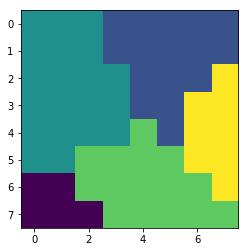

In [5]:
##this gives a 1hot encoding (1, K, D1*D2)
targetZ = very.make_object_map_stack(K, 2, 3, (D1,D2), 1)
targetZCanonical=Z.view_sample(targetZ,show=False)
plt.imshow(targetZCanonical)

Simulate responses from our experiment

In [7]:

##response object
r = very.responses(Z,nP)
r.set_values(windows=windows)
data = r.sample(targetZ,pon,poff)
r.set_values(data=data)

print 'total observations: %d' %(r.N)

total observations: 504


(array([  6.,  66., 140., 174., 100.,  18.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

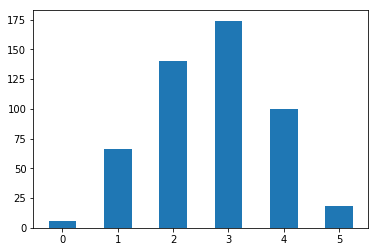

In [8]:
plt.hist(r.observations,bins=range(0,K+2),rwidth = .5, align='left')

### Train the model on the fake responses

In [9]:
pdb on

Automatic pdb calling has been turned ON


In [10]:
##instantiate the variational inferences we want to perform
iqZ = very.inferQZ()
iqPi = very.inferQPi()

##...and the parameter optimizations (point-estimate) we want
oNP = very.optimizeNoiseParams()

##variational inference combines them all together
vi = very.VI(r, iqZ,oNP, iqPi)

### Run variational inference

##inference algorithm parameters
initialNoisinessOfZ = 0.2
pOn_init, pOff_init = .95, 0.05
densityOfNoiseParamGrid = 50
numStarterMaps = 50
numSamplesForComputingObjectCountProbs = 4
maxNumIterations = 100
trainTestSplit = .9
trainRegSplit = .8
pixelNumOverMin = 2
objectNumOverMin = 2

bestModel,_=vi.run_VI(initialNoisinessOfZ, \
                     pOn_init, pOff_init, \
                     densityOfNoiseParamGrid, \
                     numStarterMaps, \
                     numSamplesForComputingObjectCountProbs, \
                     maxNumIterations, \
                     trainTestSplit, trainRegSplit, \
                     optimizeHyperParams=False)

!new best!
ELBO: -630.770203
goodness of fit: -674.001343
posterior_entropy: 43.231125
mean log of predictive distribution over test samples: -1.778335
percent correct over test samples: 35.555556


!new best!
ELBO: -388.940887
goodness of fit: -415.330658
posterior_entropy: 26.389769
mean log of predictive distribution over test samples: -1.416854
percent correct over test samples: 44.444444


ELBO: -372.182953
goodness of fit: -405.636627
posterior_entropy: 33.453663
mean log of predictive distribution over test samples: -1.409042
percent correct over test samples: 38.888889


!new best!
ELBO: -361.983093
goodness of fit: -394.683563
posterior_entropy: 32.700481
mean log of predictive distribution over test samples: -1.394734
percent correct over test samples: 48.888889


!new best!
ELBO: -361.991455
goodness of fit: -392.296082
posterior_entropy: 30.304642
mean log of predictive distribution over test samples: -1.328725
percent correct over test samples: 52.222222


!new best!
ELBO:

ELBO: -329.833984
goodness of fit: -335.846375
posterior_entropy: 6.012385
mean log of predictive distribution over test samples: -1.147822
percent correct over test samples: 60.000000


ELBO: -327.126190
goodness of fit: -333.379547
posterior_entropy: 6.253362
mean log of predictive distribution over test samples: -1.108850
percent correct over test samples: 61.111111


ELBO: -326.680206
goodness of fit: -332.697876
posterior_entropy: 6.017663
mean log of predictive distribution over test samples: -1.160305
percent correct over test samples: 60.000000


ELBO: -326.222229
goodness of fit: -331.775848
posterior_entropy: 5.553635
mean log of predictive distribution over test samples: -1.170008
percent correct over test samples: 58.888889


ELBO: -326.384155
goodness of fit: -332.675690
posterior_entropy: 6.291520
mean log of predictive distribution over test samples: -1.159888
percent correct over test samples: 58.888889


ELBO: -326.892456
goodness of fit: -332.919403
posterior_entropy:

ELBO: -327.843658
goodness of fit: -334.126648
posterior_entropy: 6.282981
mean log of predictive distribution over test samples: -1.142558
percent correct over test samples: 60.000000


ELBO: -328.705902
goodness of fit: -334.320831
posterior_entropy: 5.614941
mean log of predictive distribution over test samples: -1.134480
percent correct over test samples: 61.111111


ELBO: -327.268738
goodness of fit: -332.882477
posterior_entropy: 5.613746
mean log of predictive distribution over test samples: -1.175222
percent correct over test samples: 60.000000


ELBO: -327.081970
goodness of fit: -332.427216
posterior_entropy: 5.345232
mean log of predictive distribution over test samples: -1.201249
percent correct over test samples: 57.777778


ELBO: -329.595306
goodness of fit: -335.268188
posterior_entropy: 5.672876
mean log of predictive distribution over test samples: -1.194887
percent correct over test samples: 60.000000


ELBO: -326.387543
goodness of fit: -331.928345
posterior_entropy:

In [11]:
vi.bestPercentCorrect

array([64.44444444])

In [12]:
bestModel.bestPercentCorrect

array([64.44444444])

In [13]:
bestModel.update_current(bestModel.testIdx)
print bestModel.curIdx.shape
print bestModel.curResponses.shape

(50,)
(50,)


In [14]:
print very.percent_correct(bestModel)


In [15]:
print 1./K*100
old_pc = 0
for _ in range(100):
    new_pc = percent_correct()
    if new_pc != old_pc:
        print new_pc
    

20.0
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00000000000001
56.00

In [16]:
bestModel.bestNoiseParam

array([0.8971633 , 0.08237848], dtype=float32)

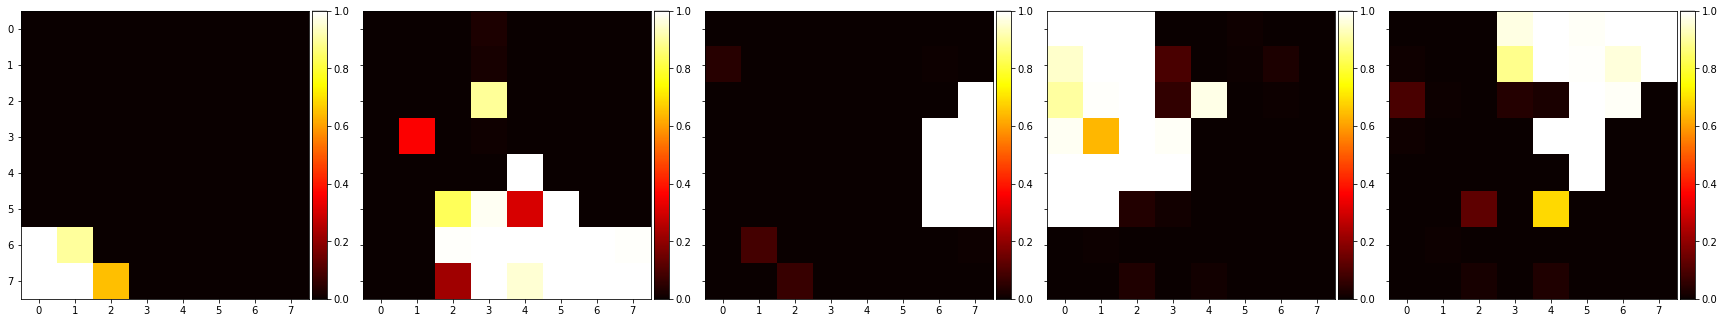

In [17]:
bestModel.see_Q_Z(bestModel.bestQZ)

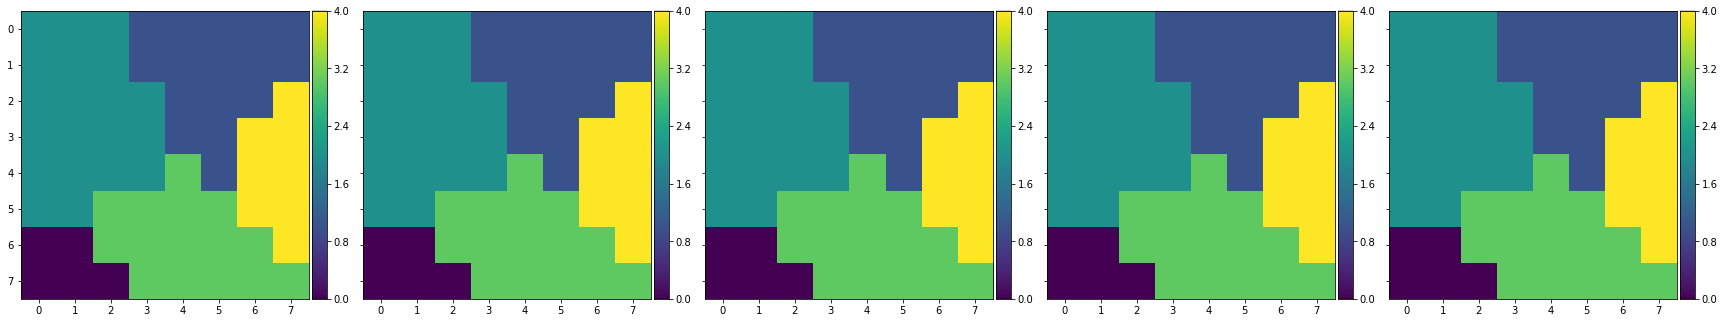

In [18]:
##view the target image, return a canonical (D1, D2) format image
targetZCanonical=Z.view_sample(targetZ,show=False)
fig=plt.figure(3,(30,10))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (1, K), # creates grid of axes
                axes_pad=0.5, # pad between axes in inch.
                cbar_mode = 'each',
                cbar_pad = .05
                )
for kk in range(0,K):
    im = grid[kk].imshow(targetZCanonical,interpolation = 'nearest')
    grid[kk].cax.colorbar(im)    


#### View target and posterior

#### Pixel entropy maps
Just map the entropy of the posterior at each pixel

#### compute KL divergence (crossentropy, entropy)

#### compute pixelwise co-membership probability maps (pixelcom map)
For each pixel, map the probability of all other pixels belonging to same object.
Create a stack of such "pixelcom" maps.
Real images will have degenerate (i.e., binary) pixelcom maps

#### Use the pixelcom maps to reconstruct target object maps
Simply average them

#### Use the pixelcom maps to perform image identification
Some how compare the pixelcom maps for real images to the pixelcom maps derived from vision/imagery experiments.

#### Use the pixelcom maps to estimate size differences and translational differences between objects in vision and imagery
take the "real" object from the target image map. 
estimate probabilities under enlargements and translations.


#### ----------------- Tossed ---------------------

In [ ]:

# ##==========construct model random variables
# ##number of objects
# nObj = numObjects()

# ##dispersion on category prior: here we set a hyperprior
# pDisp = priorDispersion()
# dispersion = 1.0
# pDisp.set_value(dispersion)

# ##resolution of object map Z
# nPixels = numPixels()

# ##category prior and object map
# catProb = categoryProbs(nObj,pDisp)
# Z = latentObjMap(catProb,nPixels)

# ##noise params
# nP = noiseParams()

# ##windows: we change their shape a little to make them easier to work with
# desiredWindowShape = (375,600)
# workingScale = 5
# w = probes()
# resolutions, workingResolution = w.resolve(desiredWindowShape, workingScale)
# w.set_value(w.reshape(windows, workingResolution),flatten=True)
# print 'working resolution is (%d, %d)' %(workingResolution[0], workingResolution[1])


# ##response object
# r = responses(Z,nP)

# ##fake data
# r.set_values(windows=w)

# r.set_values(data=resp)

# print 'total observations: %d' %(r.N)

# tMap = target_image()
# targetObjectMap_test, targetImage_test = tMap.reshape(targetObjectMap,workingResolution,targetImage=targetImage)
# tMap.set_values(targetObjectMap_test, targetImage_test)
# ##=============

# ##instantiate the variational inferences we want to perform
# iqZ = inferQZ()
# iqPi = inferQPi()

# ##...and the parameter optimizations (point-estimate) we want
# oNP = optimizeNoiseParams()

# ##variational inference combines them all together
# vi = VI(r, iqZ,oNP, iqPi)

# ### Run variational inference

# ##inference algorithm parameters
# initialNoisinessOfZ = 0.2
# pOn_init, pOff_init = .8, 0.2
# densityOfNoiseParamGrid = 50
# numStarterMaps = 20
# numSamplesForComputingObjectCountProbs = 4
# maxNumIterations = 50
# trainTestSplit = 1.0
# trainRegSplit = .8
# pixelNumOverMin = 2
# objectNumOverMin = 2

# print '=========================(subject, state, target) = (%s, %s, %s) ====' %(subject, state, targetImageName)
# bestModel = vi.run_VI(initialNoisinessOfZ, \
#                      pOn_init, pOff_init, \
#                      densityOfNoiseParamGrid, \
#                      numStarterMaps, \
#                      numSamplesForComputingObjectCountProbs, \
#                      maxNumIterations, \
#                      trainTestSplit, trainRegSplit, \
#                      optimizeHyperParams=True, pixelNumOverMin=pixelNumOverMin, objectNumOverMin=objectNumOverMin)

In [ ]:
##Create a target image, method 1: Read in an image from a real experiment


# ##a real target from a recent experiment
# ##which repo?
# drive = '/home/tnaselar/FAST/imagery_psychophysics'

# ##base directory
# base = 'multi_poly_probes'

# ##pandas dataframe with all the experimental conditions and data
# data_place = 'data'
# data_file = 'multi_poly_probe_data_3_subjects.pkl'
# subject = 'KL'
# state = 'pcp'


# ##target images
# image_place = 'masks'
# target_image_name = 'candle_01'
# target_image_file = 'candle_mask_mostbjs.tif'

# ##window files
# window_place = 'probes'
# window_file = 'candle_01_letterbox_img__probe_dict.pkl'


# ##open
# test_object_map = open_image(join(drive, base, image_place, target_image_file),mode='r').convert('L')

# ##record K
# values = np.array(np.unique(test_object_map))
# targetK = len(values)

# ##resize to window, checking for preserved K
# test_object_map=test_object_map.resize((test_object_map.size[1], test_object_map.size[0]),)
# values = np.array(np.unique(test_object_map))
# assert targetK==len(values)

# ##digitize, checking 
# test_object_map=np.digitize(test_object_map, bins=values, right=True ).astype(int)
# values = np.array(np.unique(test_object_map))
# assert targetK==len(values)

# ##one-hot encoding
# fullscreenSize = np.prod(test_object_map.size)
# test_object_map = np.eye(K)[test_object_map.ravel()].T.reshape((1,targetK,fullscreenSize))

# ##view
# test_object_map_image = see_Z_sample(test_object_map[0], window_shape, show=False)
# plt.imshow(test_object_map_image, cmap='Dark2')
# plt.imshow(W[-5].reshape(window_shape).astype('uint8')*255, interpolation='none', alpha = .2, cmap=plt.cm.gray, clim=[0,255])